In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMG_SIZE = 224
BATCH_SIZE =32
EPOCHS = 10
CHANNEL = 3

In [3]:
dataset =  tf.keras.preprocessing.image_dataset_from_directory("fruits",
                                                             image_size = (IMG_SIZE,IMG_SIZE),
                                                             batch_size = BATCH_SIZE,
                                                             shuffle= True,
                                                             )

Found 3026 files belonging to 10 classes.


In [4]:
class_name = dataset.class_names
class_name

['Apple',
 'Banana',
 'avocado',
 'cherry',
 'kiwi',
 'mango',
 'orange',
 'pinenapple',
 'strawberries',
 'watermelon']

In [5]:
def create_data_batch(dataset,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True,shuffle_size=1000):
    data_len = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)
    train_size = int(data_len*train_size)
    val_size = int(data_len*val_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

In [6]:
train_ds,test_ds,val_ds = create_data_batch(dataset)

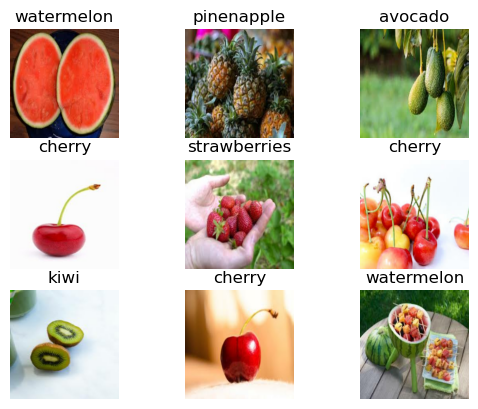

In [7]:
for image,label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
rescale_resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE)
    
])

In [10]:
INPUT_SHAPE =(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNEL)

model = tf.keras.Sequential([
    rescale_resize,
    tf.keras.layers.Conv2D(44,kernel_size=(3,3),input_shape=INPUT_SHAPE,activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(58,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)), 
    tf.keras.layers.Conv2D(60,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)), 
    tf.keras.layers.Flatten(),
    #DENSE Layers
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(10,activation="softmax")
])
       
model.build(INPUT_SHAPE)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 44)        1232      
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 44)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 58)        23026     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 58)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 60)         

In [12]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=2)

In [14]:
histroy=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[callback])

Epoch 1/10
76/76 [==============================] - 119s 2s/step - loss: 2.1482 - accuracy: 0.1865 - val_loss: 1.8702 - val_accuracy: 0.2569
Epoch 2/10
76/76 [==============================] - 118s 2s/step - loss: 1.7147 - accuracy: 0.3255 - val_loss: 1.5765 - val_accuracy: 0.4097
Epoch 3/10
76/76 [==============================] - 138s 2s/step - loss: 1.4897 - accuracy: 0.4425 - val_loss: 1.3629 - val_accuracy: 0.5104
Epoch 4/10
76/76 [==============================] - 117s 2s/step - loss: 1.2487 - accuracy: 0.5500 - val_loss: 1.0537 - val_accuracy: 0.6285
Epoch 5/10
76/76 [==============================] - 113s 1s/step - loss: 0.9652 - accuracy: 0.6576 - val_loss: 0.8223 - val_accuracy: 0.7361
Epoch 6/10
76/76 [==============================] - 113s 1s/step - loss: 0.6800 - accuracy: 0.7775 - val_loss: 0.6763 - val_accuracy: 0.7986
Epoch 7/10
76/76 [==============================] - 110s 1s/step - loss: 0.3457 - accuracy: 0.8867 - val_loss: 0.5125 - val_accuracy: 0.8681
Epoch 8/10
76

In [15]:
model.evaluate(test_ds)

10/10 [==============================] - 6s 267ms/step - loss: 0.4459 - accuracy: 0.9000


[0.44585853815078735, 0.8999999761581421]

In [17]:
model.save('Fruit-classification model v1.keras')

In [16]:
pre_trained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling='max',
    classes=10,
    classifier_activation="softmax",
)

for layers in pre_trained_model.layers:
    layers.trainable=False

In [18]:
CHANNELS =3
INPUT_SHAPE =(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)

model1 = tf.keras.Sequential([
    rescale_resize,
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(10,activation="softmax")
        
])

model1.build(INPUT_SHAPE)

In [19]:
model1.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=2)

In [21]:
histroy1 = model1.fit(train_ds,validation_data=test_ds,epochs=EPOCHS,callbacks=[callback])

Epoch 1/10
76/76 [==============================] - 61s 713ms/step - loss: 1.4242 - accuracy: 0.6344 - val_loss: 0.5152 - val_accuracy: 0.8375
Epoch 2/10
76/76 [==============================] - 51s 674ms/step - loss: 0.3931 - accuracy: 0.8801 - val_loss: 0.2428 - val_accuracy: 0.9094
Epoch 3/10
76/76 [==============================] - 50s 662ms/step - loss: 0.2401 - accuracy: 0.9260 - val_loss: 0.2002 - val_accuracy: 0.9344
Epoch 4/10
76/76 [==============================] - 50s 662ms/step - loss: 0.1469 - accuracy: 0.9529 - val_loss: 0.1292 - val_accuracy: 0.9750
Epoch 5/10
76/76 [==============================] - 51s 678ms/step - loss: 0.0887 - accuracy: 0.9735 - val_loss: 0.0784 - val_accuracy: 0.9844
Epoch 6/10
76/76 [==============================] - 51s 674ms/step - loss: 0.0647 - accuracy: 0.9814 - val_loss: 0.0943 - val_accuracy: 0.9812
Epoch 7/10
76/76 [==============================] - 51s 676ms/step - loss: 0.0280 - accuracy: 0.9963 - val_loss: 0.0516 - val_accuracy: 0.9906

In [22]:
model1.evaluate(test_ds)

10/10 [==============================] - 6s 593ms/step - loss: 0.0395 - accuracy: 0.9875


[0.03948477655649185, 0.987500011920929]

In [23]:
model1.save('fruit classification model v2.keras')

In [41]:
from keras.models import load_model

In [42]:
model_system = load_model('fruit classification model v2.keras')

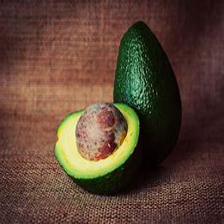

In [53]:
from PIL import Image
img = Image.open('avacao1.jpg').resize((224,224))
img

In [54]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = model_system.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 47ms/step


'avocado'